## **Connect4Dataset**
The Connect4Dataset is an implementation of the Dataset object and supposed to contain the positions including the __board__, __current player__ and __target column__ for each sample.

In [8]:
from torch.utils.data import Dataset

class Connect4Dataset(Dataset):
    def __init__(self, board_data, player_data, label_data, transform=None):
        self.board_data = board_data
        self.player_data = player_data
        self.label_data = label_data
        self.transform = transform

    def __len__(self):
        return len(self.board_data)

    def __getitem__(self, index):
        board = self.board_data[index]
        player = self.player_data[index]
        label = self.label_data[index]

        # Apply the transform (if any) to the board
        if self.transform is not None:
            board = self.transform(board)

        return board, player, label

    def add(self, board, player, column):
        self.board_data.append(board)
        self.player_data.append(player)
        self.label_data.append(column)


## **Building the Datasets**
The samples are read from the file system and put into an Connect4Dataset.

tensor([1])
tensor([[1., 0., 0., 0., 0., 0., 0.]])
tensor([0])
tensor([[0., 0., 0., 0., 0., 0., 1.]])
tensor([0])
tensor([[1., 0., 0., 0., 0., 0., 0.]])
tensor([1])
tensor([[0., 0., 0., 0., 0., 0., 1.]])
tensor([1])
tensor([[0., 0., 1., 0., 0., 0., 0.]])
tensor([1])
tensor([[0., 0., 1., 0., 0., 0., 0.]])
tensor([1])
tensor([[0., 0., 0., 0., 1., 0., 0.]])
tensor([1])
tensor([[0., 0., 0., 0., 1., 0., 0.]])
tensor([0])
tensor([[0., 0., 0., 0., 0., 1., 0.]])


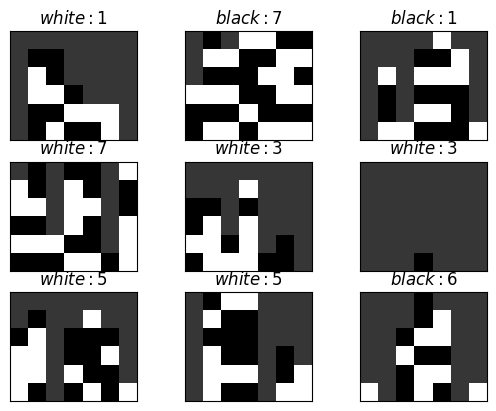

In [13]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

BATCH_SIZE = 1
NUM_EPOCHS = 10  # Number of training epochs

def build_dataset(positions_white, positions_black, num_columns = 7):
    data_transforms = transforms.Compose([
        transforms.Resize((6, 7)),  # Resize the images to a consistent size (e.g., 64x64)
        transforms.Grayscale(),       # Convert images to grayscale
        transforms.ToTensor(),        # Convert images to PyTorch tensors
    ])
    
    dataset_white = ImageFolder(positions_white, transform=data_transforms)
    dataset_black = ImageFolder(positions_black, transform=data_transforms)
    dataset = Connect4Dataset([], [], [])
    for i in range(len(dataset_white)):
        board, column = dataset_white[i]
        dataset.add(board, 1, torch.eye(num_columns)[column - 1])
    for i in range(len(dataset_black)):
        board, column = dataset_black[i]
        dataset.add(board, 0, torch.eye(num_columns)[column - 1])
    
    train_size = int(0.6 * len(dataset))  # 60% for training
    test_size = int(0.2 * len(dataset))  # 20% for testing
    val_size = len(dataset) - train_size - test_size  # 20% for validation
    train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
    
    # Create data loaders for training and testing
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for i, (board, current_player, column) in enumerate(train_loader):
        plt.subplot(331 + i)
        plt.xticks([])
        plt.yticks([])
        print(current_player)
        print(column)
        plt.title(f"${['black', 'white'][current_player]}:${np.argmax(column) + 1}")
        arr = np.asarray(board)
        arr = arr.reshape(6, 7)
        plt.imshow(arr, cmap='gray', vmin=0, vmax=1)
        if i == 8:
            break
    plt.show()
    return train_loader, test_loader, validation_loader

training, testing, validation = build_dataset('connect4/white', 'connect4/black')

## **Model**
As model, we use a CNN. It operates on the image of the board and stacks multiple convolutional layers together to enable Pattern recognition.
It is then followed by a four layer dense neural network. The first vector of the dense neural network also receives the current player as second input. The produced output vector has length 7. It contains the estimated probabilities of putting the next token in the respective column being the best move.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bot(torch.nn.Module):

    def __init__(self):
        super(Bot, self).__init__()

        self.conv1 = nn.Conv2d(1, 100, (2, 2))
        #self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 200, (2, 2))
        #self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(200, 300, (2, 2))
        #self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(300, 400, (2, 2))
        #self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 2 * 400 + 1, 42)
        self.fc2 = nn.Linear(42, 42)
        self.fc3 = nn.Linear(42, 42)
        self.fc4 = nn.Linear(42, 42)
        self.fc5 = nn.Linear(42, 42)
        self.fc6 = nn.Linear(42, 42)
        self.fc7 = nn.Linear(42, 7)
        print(self)


    def forward(self, board, current_player):
        x = F.relu(self.conv1(board))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = torch.cat((x, current_player.unsqueeze(1)), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

## **Training the model**
As loss function we use CrossEntropy and as Optimizer SGD.

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

def train(num_epochs):
    bot = Bot()
    binary_cross_entropy = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(bot.parameters(), lr=0.01, momentum=0.9)
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for board_sample, current_player, best_move in training:
            outputs = bot(board_sample, current_player)
            loss = binary_cross_entropy(outputs, best_move)
            running_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        print(f"epoch {epoch} --- loss: {running_loss}")
    print("Training completed.")
    return bot

def get_accuracy(bot, dataset):
    total = 0
    correct = 0
    for board_sample, current_player, best_move in dataset:
        outputs = bot(board_sample, current_player)
        predicted_indices = torch.argmax(outputs, dim=1)
        labeled_indices = torch.argmax(best_move, dim=1)
        total += best_move.size(0)
        correct += (predicted_indices == labeled_indices).sum().item()

    return 100 * correct / total

model = train(NUM_EPOCHS)

## **Testing the model**
We give the model the test subset and calculate the accuracy.


In [ ]:
model.eval()  # Set the model to evaluation mode
test_acc = get_accuracy(model, testing)
print(f"Accuracy on the test set: {test_acc:.2f}%")

training_acc = get_accuracy(model, training)
print(f"Accuracy on the training set: {training_acc:.2f}%")